<a href="https://colab.research.google.com/github/Bangkit-Capstone-C241-BB01/BlurOrBokeh_ML_All/blob/main/%5B0%5D_Model_Performance_Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real Image Model Evaluation

## Setup

In [ ]:
import os
import sys
import PIL
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer, Input, Flatten, Dense, Concatenate, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

PIL.Image.MAX_IMAGE_PIXELS = None

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
base_dir = "/content/drive/My Drive/Blur or Bokeh"

data_dir = os.path.join(base_dir, "Dataset")
library_dir = os.path.join(base_dir, "Library")
serialized_data_dir = os.path.join(base_dir, "Serialized Data")
braincore_data_dir = os.path.join(data_dir, "Braincore")

train_dir = os.path.join(data_dir, "Combined Training Data")
train_val_dir = os.path.join(braincore_data_dir, "val")
validation_dir = os.path.join(braincore_data_dir, "test")
test_dir = os.path.join(data_dir, "Real Image Test")

sys.path.append(library_dir)
from cf_matrix import make_confusion_matrix

class_names = ["Blur", "Bokeh", "Normal"]

## Load the Dataset

*   All models accept 150x150 as image input size, except model on section 1 of Model Summary.
*   `preprocessing_function` is used only on model on section 5 of Model Summary, which utilized FFT as preprocessing.

In [ ]:
# image_size = (150, 150)
image_size = (299, 299) # special for [TL InceptionV3]

datagen = ImageDataGenerator(
    # preprocessing_function=fft_preprocessing,
    rescale=1./255
)
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=128,
    class_mode="sparse"
)
train_val_generator = datagen.flow_from_directory(
    train_val_dir,
    target_size=image_size,
    batch_size=128,
    class_mode="sparse"
)
validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=2000,
    class_mode="sparse",
    shuffle=False
)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=2000,
    class_mode="sparse",
    shuffle=False
)

Found 2910 images belonging to 3 classes.
Found 328 images belonging to 3 classes.
Found 114 images belonging to 3 classes.
Found 65 images belonging to 3 classes.


## Helper Function

In [ ]:
X_train, y_train = next(train_generator)
X_train_val, y_train_val = next(train_val_generator)
X_val, y_val = next(validation_generator)
X_test, y_test = next(test_generator)

def plot_error(test_pred):
    error_image = X_test[test_pred != y_test]
    error_label = tf.cast(y_test[test_pred != y_test], tf.int32)
    error_pred = test_pred[test_pred != y_test]

    num_row = 5
    num_col = 4
    subplot_size = 3
    plt.figure(figsize=(num_col*subplot_size, num_row*subplot_size))
    for i in range(len(error_image)):
        plt.subplot(num_row, num_col, i+1)
        plt.imshow(error_image[i])
        plt.axis("off")
        plt.title(f"True: {class_names[error_label[i]]}\nPredicted: {class_names[error_pred[i]]}", fontsize=10)
    plt.tight_layout()
    plt.show()

def evaluate_model(model, show_loss=[]):
    df_data = {"Accuracy": [], "Loss": []}
    df_index = []

    if "train" in show_loss or show_loss == "all":
        loss, acc = model.evaluate(train_generator)
        df_data["Accuracy"].append(acc)
        df_data["Loss"].append(loss)
        df_index.append("Train")

    if "train_val" in show_loss or show_loss == "all":
        loss, acc = model.evaluate(train_val_generator)
        df_data["Accuracy"].append(acc)
        df_data["Loss"].append(loss)
        df_index.append("Train-Validation")

    if "val" in show_loss or show_loss == "all":
        loss, acc = model.evaluate(validation_generator)
        df_data["Accuracy"].append(acc)
        df_data["Loss"].append(loss)
        df_index.append("Validation")

    if "test" in show_loss or show_loss == "all":
        loss, acc = model.evaluate(test_generator)
        df_data["Accuracy"].append(acc)
        df_data["Loss"].append(loss)
        df_index.append("Test")

    df = pd.DataFrame(data=df_data, index=df_index).applymap(lambda x: round(x, 4))
    display(df)

def show_cm(model, split="test", return_test_pred=False):
    global_namespace = globals()
    X = global_namespace[f"X_{split}"]
    y = global_namespace[f"y_{split}"]

    test_pred = model.predict(X)
    test_pred = tf.argmax(test_pred, axis=1)
    cm = confusion_matrix(y, test_pred)
    make_confusion_matrix(cm, categories=class_names, cmap="Greens", cbar=False)

    if return_test_pred:
        return test_pred

## Model Summary

### 1. TL InceptionV3

In [ ]:
pre_trained_model = InceptionV3(
    input_shape=(299, 299, 3),
    include_top=False,
    weights=None
)
last_layer = pre_trained_model.output
x = GlobalAveragePooling2D()(last_layer)
x = Dense(1024, activation='relu')(x)
x = Dense(3, activation="softmax")(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#### 1.1. Best Accuracy

3/3 [==============================] - 14s 4s/step


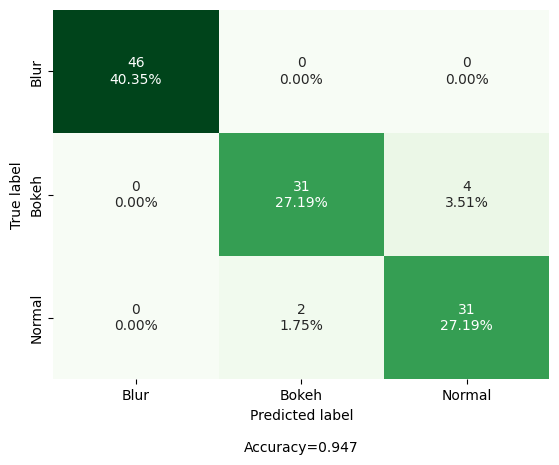

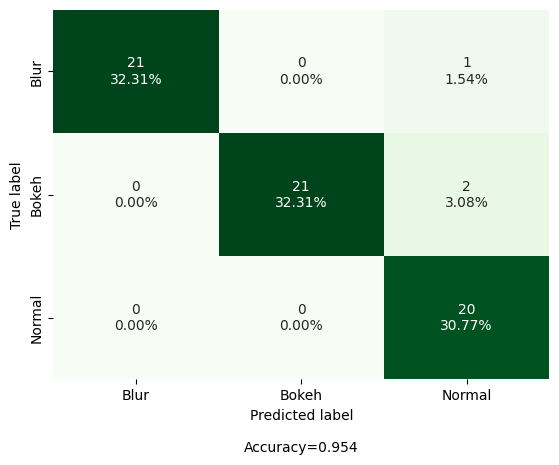

In [ ]:
model.load_weights(os.path.join(serialized_data_dir, "TL InceptionV3_95.h5"))
# evaluate_model(model, show_loss="all")
show_cm(model, split="val")
show_cm(model)

#### 1.2. Most Suitable

3/3 [==============================] - 15s 4s/step


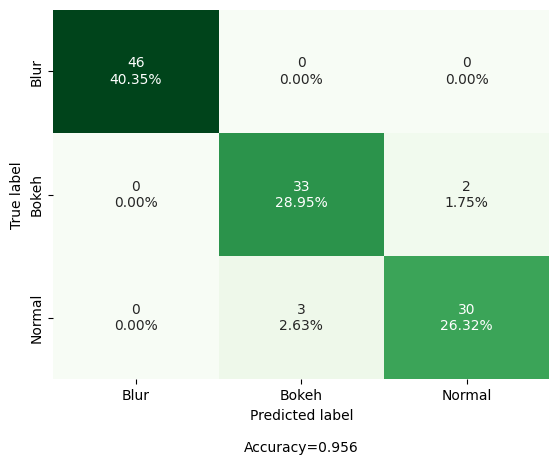

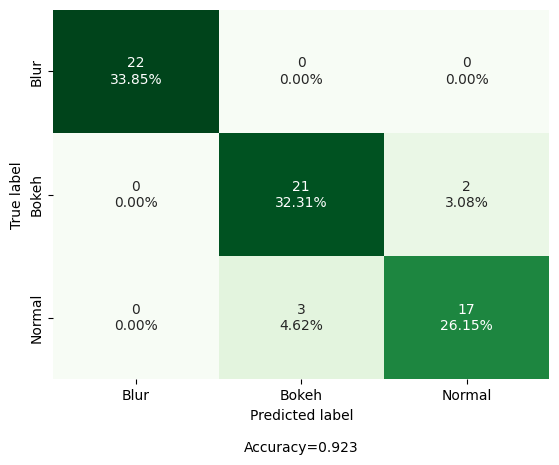

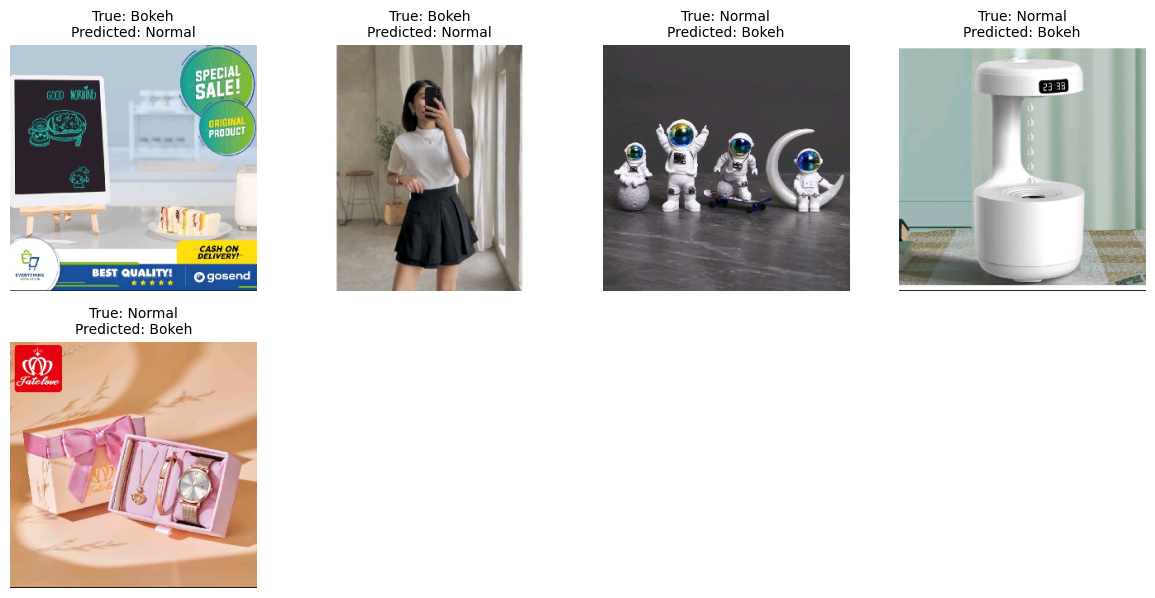

In [ ]:
model.load_weights(os.path.join(serialized_data_dir, "TL InceptionV3_96.h5"))
# evaluate_model(model, show_loss="all")
show_cm(model, split="val")
plot_error(show_cm(model, return_test_pred=True))

### 2. TL InceptionV3 (mixed3)

For the following section, TL refers to transfer learning using InceptionV3 until layer `mixed3`.

3/3 [==============================] - 2s 349ms/step


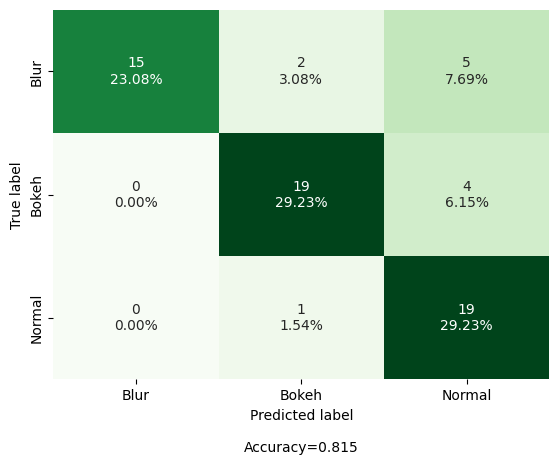

In [ ]:
pre_trained_model = InceptionV3(
    input_shape=image_size + (3,),
    include_top=False,
    weights=None
)
last_layer = pre_trained_model.get_layer("mixed3").output

x = BatchNormalization()(last_layer)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(3, activation="softmax")(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.load_weights(os.path.join(serialized_data_dir, "TL InceptionV3 (mixed3)_86.h5"))

show_cm(model)

### 3. Weighted Loss + TL

3/3 [==============================] - 3s 350ms/step


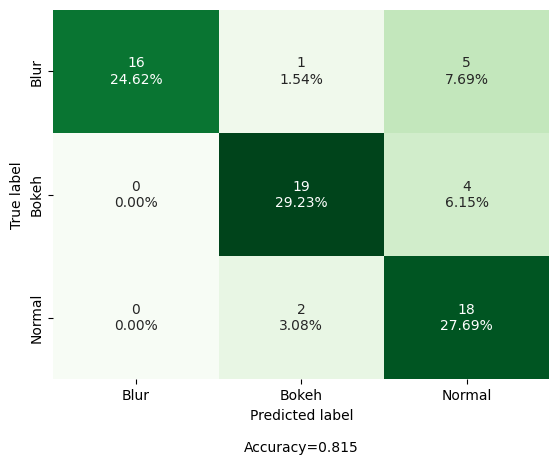

In [ ]:
def weighted_loss(y_true, y_pred):
    class_weights = [3.0, 1.0, 1.0]
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    weight = tf.gather(class_weights, tf.cast(y_true, tf.int32))
    weighted_loss = loss * weight
    return tf.reduce_mean(weighted_loss)

pre_trained_model = InceptionV3(
    input_shape=image_size + (3,),
    include_top=False,
    weights=None
)
x = pre_trained_model.get_layer("mixed3").output

x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(3, activation="softmax")(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer=Adam(), loss=weighted_loss, metrics=["accuracy"])
model.load_weights(os.path.join(serialized_data_dir, "TL + Weighted Loss_87.h5"))

show_cm(model)

### 4. Variance + TL


3/3 [==============================] - 2s 414ms/step


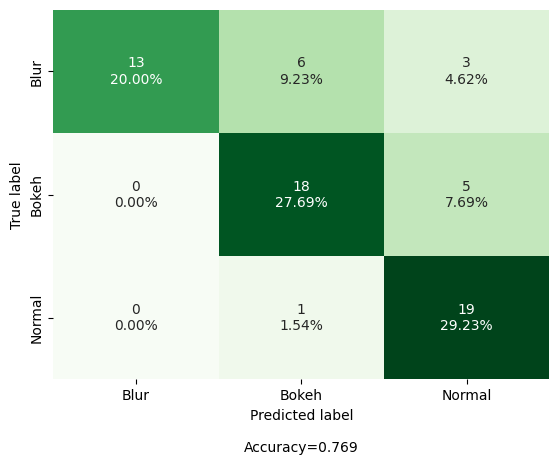

In [ ]:
class TransformedVarianceOfLaplacian(Layer):
    def __init__(self, **kwargs):
        super(TransformedVarianceOfLaplacian, self).__init__(**kwargs)
        self.laplacian_filter = tf.constant([[[[ 0]], [[-1]], [[ 0]]],
                                             [[[-1]], [[ 4]], [[-1]]],
                                             [[[ 0]], [[-1]], [[ 0]]]], dtype=tf.float32)

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, inputs):
        result = tf.py_function(self.wrapper, [inputs], Tout=tf.float32)
        result.set_shape((None, 1))
        return result

    def wrapper(self, inputs):
        result = []
        for image in inputs:
            gray_image = tf.image.rgb_to_grayscale(image)
            conv_image = tf.nn.conv2d(gray_image[tf.newaxis, ...], self.laplacian_filter, strides=[1, 1, 1, 1], padding="VALID")

            variance = tf.math.reduce_variance(conv_image)
            max = tf.math.reduce_max(conv_image)
            min = tf.math.reduce_min(conv_image)

            result.append([variance, min, max])

        result = tf.convert_to_tensor(result)
        power = tf.math.divide(tf.math.exp(result[:, 1]), tf.math.exp(result[:, 2]))
        result = tf.math.pow(result[:, 0], power)

        return result[..., tf.newaxis]

pre_trained_model = InceptionV3(
    input_shape=image_size + (3,),
    include_top=False,
    weights=None
)
input_layer = Input(shape=image_size + (3,), name="input_layer")

inception_model = Model(
    inputs=pre_trained_model.input,
    outputs=pre_trained_model.get_layer("mixed3").output,
    name="inception_model"
)
feature_extractor = inception_model(input_layer)
feature_extractor = Flatten(name="flatten")(feature_extractor)

variance_extractor = TransformedVarianceOfLaplacian(name="transformed_variance")(input_layer)

x = Concatenate(name="mixed")([feature_extractor, variance_extractor])
x = BatchNormalization(name="batch_normalization")(x)

x = Dense(512, activation="relu", name="dense_1")(x)
x = Dense(128, activation="relu", name="dense_2")(x)
x = Dense(64, activation="relu", name="dense_3")(x)
x = Dense(32, activation="relu", name="dense_4")(x)
x = Dense(3, activation="softmax", name="output_layer")(x)

model = Model(input_layer, x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.load_weights(os.path.join(serialized_data_dir, "TL + Variance_90.h5"))

show_cm(model)

### 5. FFT + TL

In [ ]:
def fft_preprocessing(image):
    image = tf.cast(image, tf.float32)
    image_fft = tf.signal.fft2d(tf.cast(image, tf.complex64))
    image_fft = tf.abs(image_fft)
    image_fft = tf.math.log(image_fft + 1e-8)
    return image_fft

3/3 [==============================] - 2s 355ms/step


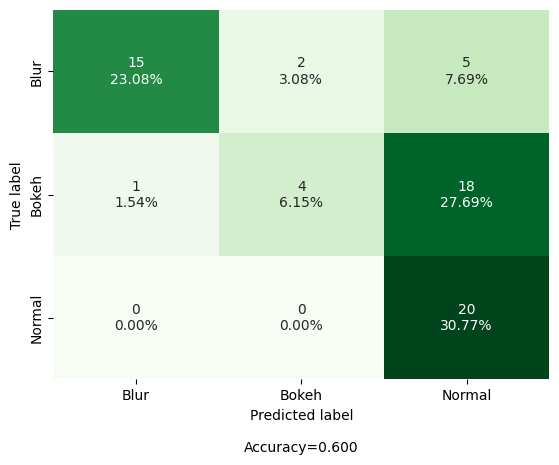

In [ ]:
class FastFourierTransform(Layer):
    def __init__(self, **kwargs):
        super(FastFourierTransform, self).__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, inputs):
        result = tf.py_function(self.wrapper, [inputs], Tout=tf.float32)
        result.set_shape([None, 150, 150, 3])
        return result

    def wrapper(self, inputs):
        result = []
        for image in inputs:
            image = tf.signal.fft2d(tf.cast(image, tf.complex64))
            image = tf.abs(image)
            image = tf.math.log(image + 1e-8)

            result.append(image)
        return tf.convert_to_tensor(result)

pre_trained_model = InceptionV3(
    input_shape=image_size + (3,),
    include_top=False,
    weights=None
)
last_layer = pre_trained_model.get_layer("mixed3").output

x = BatchNormalization()(last_layer)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(3, activation="softmax")(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.load_weights(os.path.join(serialized_data_dir, "TL + FFT_81.h5"))

show_cm(model)

In [ ]:
evaluate_model(model, show_loss=["val","test"])

1/1 [==============================] - 17s 17s/step - loss: 0.4206 - accuracy: 0.9231


,Accuracy,Loss
Validation,0.9561,0.4772
Test,0.9231,0.4206
